## Variational AutoEncoder - Part 1

In [46]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from geomstats.hypersphere import Hypersphere, HypersphereMetric

In [2]:
np.random.seed(0) # setting the seed in order to make it fixed

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
reshape=True # Only for GAN for encoder it is different boolean

In [4]:
# Normalizing the values to be between 0 and 1 since the values are in gray scales 
# in between 0 and 255
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [5]:
# Reshape the training and testing data to be as an one dimensional array
if reshape:
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


### VAE Network Parameters

In [7]:
original_dimensions = x_train.shape[1]
hidden_layer_size = 512
batch_size = 128
latent_dim = 2
epochs = 50

### VAE: -> Encoder - from image to the latent parameters, decoder, reparametrization trick

In [8]:
# Input fed to the autoencoder is of the form of the batch size and the dimension of the image
inputs = Input(shape=(original_dimensions,), name='encoder_input')
h = Dense(hidden_layer_size, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='g_mean')(h)
z_log_sigma = Dense(latent_dim, name='g_variance')(h)

W0827 10:17:38.891824 140529485940544 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 10:17:38.962581 140529485940544 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 10:17:38.966213 140529485940544 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [9]:
def parametrization(args):
    # REPARAMETRIZATION TRICK
    m, v = args
    epsilon = tf.random.normal(shape=(2,))
    return m + K.exp(0.5 * v) * epsilon

In [10]:
# Get the combined z value from the function using the mean and sigma learnt by the autoencoder
z = Lambda(parametrization)([z_mean, z_log_sigma])

In [11]:
decoder_h = Dense(hidden_layer_size, activation='relu', name='decode_intermediate')
decoder_mean = Dense(original_dimensions, activation='sigmoid', name='decode_full')

In [12]:
# Same dimensions of the layers as the encoders but takes in the opposite way - as the autoencoder should
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [13]:
# encoder, from inputs to latent space
encoder = Model(inputs, z)

In [14]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [15]:
# end-to-end autoencoder - defining the input and output points
vae = Model(inputs, x_decoded_mean)

### Loss is calculated using reconstruction loss and KL divergence term

In [16]:
def total_loss(x, x_decoded_mean):
    rcons_loss = binary_crossentropy(x, x_decoded_mean)
    rcons_loss *= original_dimensions
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return rcons_loss + kl_loss

vae.compile(optimizer='adam', loss=total_loss)

W0827 10:17:44.404623 140529485940544 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 10:17:44.424201 140529485940544 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0827 10:17:44.431711 140529485940544 deprecation.py:323] From /home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
x_decoded_mean.shape

TensorShape([Dimension(None), Dimension(784)])

In [18]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [19]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
decode_intermediate (Dense)  (None, 512)               1536      
_________________________________________________________________
decode_full (Dense)          (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [20]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [21]:
# Fit the model to the data but labels and data would be the same since it is a generative model
# vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.fit(x_train,x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

W0827 10:17:48.557444 140529485940544 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 13s 214us/step - loss: 199.5473 - val_loss: 172.3617
Epoch 2/50
60000/60000 [==============================] - 14s 229us/step - loss: 169.5889 - val_loss: 166.0334
Epoch 3/50
60000/60000 [==============================] - 13s 218us/step - loss: 164.6968 - val_loss: 162.2989
Epoch 4/50
60000/60000 [==============================] - 13s 222us/step - loss: 161.9775 - val_loss: 160.1150
Epoch 5/50
60000/60000 [==============================] - 12s 202us/step - loss: 159.9950 - val_loss: 158.5966
Epoch 6/50
60000/60000 [==============================] - 10s 165us/step - loss: 158.6464 - val_loss: 157.3269
Epoch 7/50
60000/60000 [==============================] - 11s 178us/step - loss: 157.4878 - val_loss: 156.5474
Epoch 8/50
60000/60000 [==============================] - 9s 150us/step - loss: 156.5853 - val_loss: 155.9595
Epoch 9/50
60000/60000 [==============================] - 9s 15

In [22]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [23]:
x_test_encoded.shape

(10000, 2)

In [24]:
x_test_encoded[:10]

array([[ 0.60373247, -3.3774846 ],
       [ 0.9944272 ,  2.184112  ],
       [ 4.9328556 ,  0.887098  ],
       [-1.6195155 ,  0.5985508 ],
       [-1.071984  , -1.3959873 ],
       [ 3.6856503 ,  0.9138318 ],
       [-0.33478954, -1.480815  ],
       [-1.1353389 , -1.3443902 ],
       [-0.19306166, -0.25208542],
       [ 0.70092744, -1.8252583 ]], dtype=float32)

### Generating the new digits

In [25]:
# display a 2D manifold of the digits
n = 15  # number of digits to be generated
digit_size = 28 # Size of the digits
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
x
        # Looking in the Z-sample space with the dimensions for x and y
        # 0.2 is basically trying to bound the set of items you can intake - so it is a parameter
        z_sample = np.array([[xi, yi]]) * 0.2
        # Put the values of the Z sample space in the decoder
        x_decoded = generator.predict(z_sample)
        # Reshape the digit into 28*28 - 2D thingy!
        digit = x_decoded[0].reshape(digit_size, digit_size)
        # Assign the digit into the output set 
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

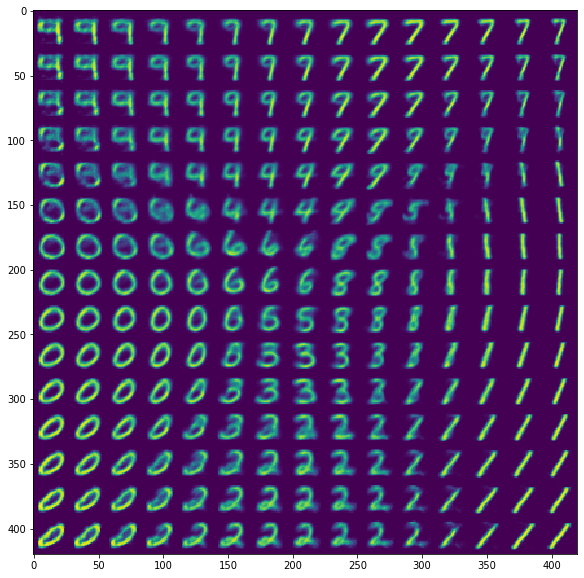

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Latent space - centroids, sampling strategies - linear, spherical, lagrange, riemannian metric

### 1. centroids

In [27]:
## Making centroids for each of the cluster
centroids = dict()
unique_labels = np.unique(y_test)
for i in unique_labels:
    cluster_indices = np.where(y_test == i)[0]
    cluster_points = x_test_encoded[cluster_indices]
    
    # Calculate the median not the mean since it ignores outliers 
    # and find the centroid based on the distribution of the points
    median_one = np.median(cluster_points[:, 0])
    median_two = np.median(cluster_points[:, 1])
    centroids[median_one] = median_two
    
print(centroids)

{-2.0677042: 0.6300469, 3.0764918: 0.44586825, -0.09088448: 2.210374, 0.105850995: 0.8908372, -0.34693897: -1.3203566, 0.1469493: 0.19919236, -0.5775398: -0.17379992, 0.38293663: -2.7153192, 0.41867182: 0.26943165, -0.32685903: -1.7830024}


In [28]:
# need to convert it into list - because dict_keys and dict_values - code smell!
centroids_keys = list(centroids.keys())
centroids_vals = list(centroids.values())

In [29]:
def generate_images_interp(x_vals, y_vals, n=10):
    ## Helper function: to generate images based on values
    ## of X and Y generated from the interpolation function
    # display a 2D manifold of the digits
    digit_size = 28 # Size of the digits
    interp_figure = np.zeros((digit_size * n, digit_size))
    cnt = 0

    for i in zip(x_vals, y_vals):
        xi, yi = i[0], i[1]
        z_val = np.array([[xi, yi]])
        x_decoded = generator.predict(z_val)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        interp_figure[cnt * digit_size: (cnt + 1) * digit_size] = digit
        cnt += 1
    
    plt.figure(figsize=(10, 10))
    plt.imshow(interp_figure)
    plt.show()

In [30]:
## Linear Interpolation
## Written by myself but will use SCIPY later.
## Lets do it between centroids 7 and 9
t = 20
x_1 = centroids_keys[7]
x_2 = centroids_keys[2]
y_1 = centroids_vals[7]
y_2 = centroids_vals[2]
fixed_t_x_vals = np.linspace(x_1, x_2, t)
fixed_t_y_vals = []
for x_n in fixed_t_x_vals:
    y_n = y_1 + ((y_2 - y_1)/(x_2 - x_1)) * (x_n - x_1)
    fixed_t_y_vals.append(y_n)

In [31]:
## Spherical Interpolation - use same value of t as above since it is global
## Much better
angle_param = np.linspace(0, 1, 20)
start_vector = np.array([x_1, y_1])
end_vector = np.array([x_2, y_2])
# Normalizing the vector since SLERP works on that
start_vector_norm = start_vector / np.sqrt(np.sum(start_vector ** 2))
end_vector_norm = end_vector / np.sqrt(np.sum(end_vector ** 2))
# To check how close they are or not, if they are too close - linear interpolation would do.
dot_of_vectors = np.dot(start_vector_norm, end_vector_norm)
# clipped_vector = np.clip(dot_of_vectors, -1, 1) # to put in the range of cos and sin, otherwise it might give some issues
# Finding the angle theta0 between original vectors 
theta_0 = np.arccos(dot_of_vectors)
sin_theta_0 = np.sin(theta_0)
theta = theta_0 * angle_param
sin_theta = np.sin(theta)
# # Finding the orthogonal vector to the start vector so that we can apply the orthogonality principle
s0 = np.cos(theta) - dot_of_vectors * sin_theta / sin_theta_0
s1 = sin_theta / sin_theta_0
slerped_result = (s0[:,np.newaxis] * start_vector[np.newaxis,:]) + (s1[:,np.newaxis] * end_vector[np.newaxis,:])

In [32]:
slerped_result

array([[ 0.38293663, -2.71531916],
       [ 0.84612228, -3.47365555],
       [ 1.28765671, -4.14310538],
       [ 1.6962416 , -4.70653827],
       [ 2.06142176, -5.14953665],
       [ 2.37385268, -5.46076475],
       [ 2.62553964, -5.63225862],
       [ 2.81004228, -5.65962995],
       [ 2.92263942, -5.54217834],
       [ 2.96044982, -5.28290922],
       [ 2.92250596, -4.88845699],
       [ 2.80977879, -4.36891518],
       [ 2.62515285, -3.73757822],
       [ 2.37335248, -3.01060126],
       [ 2.06082096, -2.20658672],
       [ 1.69555558, -1.34610836],
       [ 1.28690302, -0.45118474],
       [ 0.8453202 ,  0.45528414],
       [ 0.38210668,  1.35010285],
       [-0.09088447,  2.2103741 ]])

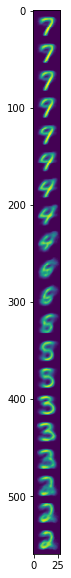

In [33]:
## Results for linear interpolation
generate_images_interp(fixed_t_x_vals, fixed_t_y_vals, n=20)

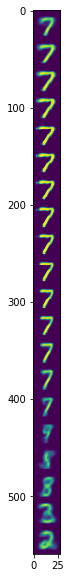

In [34]:
## Results for Spherical Interpolation
## Much more sharper results!
generate_images_interp(slerped_result[:,0], slerped_result[:,1], n=20)

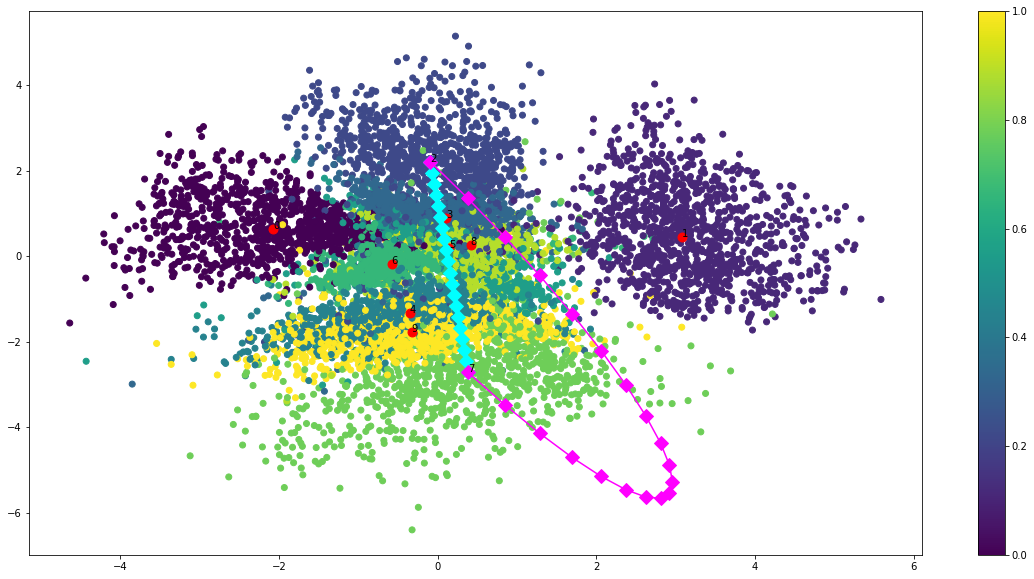

In [112]:
# Plotting the graph for consistency and looking where does each class belong
plt.figure(figsize=(20, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.scatter(centroids.keys(), centroids.values(), color='red', s=80)
plt.plot(fixed_t_x_vals, fixed_t_y_vals, '-D',color='cyan', markersize=10) # for linear interpolation
plt.plot(slerped_result[:,0], slerped_result[:,1], '-D',markersize=10, color='fuchsia') # for spherical interpolation


for i, key in enumerate(centroids_keys):
    plt.annotate(i, (key, centroids_vals[i]))

plt.colorbar()
plt.show()

## GANs in general

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
from keras.models import Sequential
from keras.layers import Reshape, Flatten, LeakyReLU, BatchNormalization

In [ ]:
print(x_train.shape, y_train.shape)

In [ ]:
image_shape = (28, 28, 1)

In [ ]:
latent_space_dimensions = (100,)
latent_input = Input(shape=latent_space_dimensions)

In [ ]:
def build_discriminator():
    # Shape of the image which is in 1D - 784 pixels and in 2D it is 28 * 28 pixels
    model = Sequential()
    # Flatten the image into 1D from 2D image
    img = Input(shape=image_shape)
    flattened_image = Flatten(input_shape=image_shape)(img)
    # Add a fully connected layer with leaky relu
    first_fc = Dense(512)(flattened_image)
    first_act = LeakyReLU(alpha=0.2)(first_fc)
    # Add another fully connected layer
    second_fc = Dense(256)(first_act)
    second_act = LeakyReLU(alpha=0.2)(second_fc)
    outputs = Dense(1, activation='sigmoid')(second_act)
    
    return Model(img, outputs)

In [ ]:
def build_generator():
    # Dimensions of the latent space point
    model = Sequential()
    # Putting into the input in the first FC layer and upsample
    first_fc = Dense(256)(latent_input)
    first_act = LeakyReLU(alpha=0.2)(first_fc)
    first_bn = BatchNormalization(momentum=0.8)(first_act)
    # Putting in the second and third FC layer
    second_fc = Dense(512)(first_bn)
    second_act = LeakyReLU(alpha=0.2)(second_fc)
    second_bn = BatchNormalization(momentum=0.8)(second_act)

    third_fc = Dense(1024)(second_bn)
    third_act = LeakyReLU(alpha=0.2)(third_fc)
    third_bn = BatchNormalization(momentum=0.8)(third_act)
    
    # Since we normalized it between 0 and 1 at the start, we use the sigmoid activation function
    generated_image = Dense(x_train.shape[1] * x_train.shape[2], activation='sigmoid')(third_bn)
    reshaped_image = Reshape(image_shape)(generated_image)
    
    return Model(latent_input, reshaped_image)

In [ ]:
generator = build_generator()
reshaped_image = generator(latent_input)
generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
discriminator = build_discriminator()
real_or_fake = discriminator(reshaped_image)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
discriminator.trainable = False

In [ ]:
gan_model = Model(latent_input, real_or_fake)
gan_model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
def summarise_performance(epoch):
    dimensions = 5
    g_number = 5
    
    latent_space_points = np.random.normal(0, 1, (dimensions * g_number, 100))
    gen_imgs = generator.predict(latent_space_points)

    fig, axs = plt.subplots(dimensions, g_number)
    cnt = 0
    for i in range(dimensions):
        for j in range(g_number):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/home/harshdeep/mnist_%d.png" % epoch)
    plt.close()

In [ ]:
def train(epochs, batch_size=128, eval_time=100):
    train = np.expand_dims(x_train, axis=3)
    half_batch = int(batch_size / 2)

    for epoch in tqdm_notebook(range(epochs)):
        idx = np.random.randint(0, train.shape[0], half_batch)
        real_images = train[idx]

        noise = np.random.uniform(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        g_loss = gan_model.train_on_batch(noise, valid_y)

        # Write the accuracy for every 50 steps and for 3000 steps save photos
        if epoch % 50 == 0:
            print('For DISCRIMINATOR epoch: {} - REAL loss is: {} -- FAKE loss is : {}'.format(
                epoch, d_loss_real, d_loss_fake))
            print('For GENERATOR epoch: {} loss is: {}'.format(epoch, g_loss))

        if ((epoch % eval_time == 0) or (epoch == (epochs - 1))):
            summarise_performance(epoch)


In [ ]:
# Train the model on 10000 epochs - could be changed with eval on ever 500 epochs
train(50000, batch_size=64, eval_time=3000)

## cGANs in general

## VAE-cGAN in general